# 定义模型 11,13,16,19

In [2]:
import torch.nn as nn
import torch

# official pretrain weights
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
}


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model


In [4]:
# vgg_model = vgg(model_name = 'vgg13')
# print(vgg_model)

# 训练

In [3]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

image_path =  "../data/flower_data"
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
train_num = len(train_dataset)

#   雏菊          蒲公英         玫瑰      向日葵       郁金香
# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 8
# nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
# print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)
print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))

# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()

model_name = "vgg16"
net = vgg(model_name=model_name, num_classes=5, init_weights=True)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs = 10
best_acc = 0.0
save_path = './{}Net.pth'.format(model_name)
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

using cuda:0 device.
using 3306 images for training, 364 images for validation.
100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.01it/s]
[epoch 1] train_loss: 1.452  val_accuracy: 0.371
100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.18it/s]
[epoch 2] train_loss: 1.322  val_accuracy: 0.420
100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.27it/s]
[epoch 3] train_loss: 1.313  val_accuracy: 0.398
100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.19it/s]
[epoch 4] train_loss: 1.327  val_accuracy: 0.426
100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.85it/s]
[epoch 5] train_loss: 1.309  val_accuracy: 0.404
100%|██████████████████████████████████████████████████████████████████████

# 预测

class: daisy        prob: 0.274
class: dandelion    prob: 0.515
class: roses        prob: 0.0948
class: sunflowers   prob: 0.0312
class: tulips       prob: 0.0849


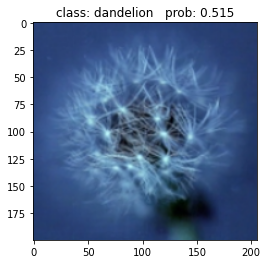

In [4]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load image
img_path = "./1.jpg"
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = vgg(model_name="vgg16", num_classes=5).to(device)
# load model weights
weights_path = "./vgg16Net.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path, map_location=device))

model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()

